### <div align="center">***ALGORITMO DE CNN PARA DETECCIÓN DE CANCER CERVICAL***</div>
***
Clasificador automatico de imágenes de frotis cervicovaginales al microscopio óptico mediante redes neuronales convolucionales (modelo supervisado).

1. [Imports](#IMPORT-LIBRARIES-AND-UTILS)
2. [Dataset info](#1-dataset-info)
3. [Preparacion de datos para el entrenamiento](#id3) 
4. [Arquitectura del modelo](#id4)
5. [Entrenamiento del modelo](#id5)
6. [Evaluación del modelo](#id6)<br></br>

### **IMPORTS**

In [23]:
from utils.utils import IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS, BATCH_SIZE, PATIENCE, EPOCHS, DATA_PATH, loadImage, balanceData

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os   # Manipulacion de directorios y archivos del ordenador.
import random

import cv2  # Procesamiento y lectura de imágenes (visión artificial).
from skimage.io import imread  # Procesamiento y lectura de imágenes.
              
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

### **DATASET INFO**

In [24]:
# DATAFRAME CON LOS NOMBRES DE LAS IMAGENES Y SU CATEGORIA (X,Y)

files = os.listdir(DATA_PATH)  # Lista de los nombres de los archivos en el directorio especificado.
category = [0 if 'normal' in file else 1 for file in files]  # Columna con la categoría (tag) de la imagen: celulas normales(0) o celulas atipicas(1).
df_cito = pd.DataFrame({
            'filename (X)' : files,
            'category (Y)' : category }).sample(frac=1, random_state=14, ignore_index=True) # Aleatorizamos el orden de las filas para minimizar sesgos en la seleccion de datos.

df_cito

,filename (X),category (Y)
0,atipica- (254).bmp,1
1,atipica- (1494).bmp,1
2,atipica- (717).bmp,1
3,normal- (2039).bmp,0
4,normal- (1425).bmp,0
...,...,...
4044,normal- (1662).bmp,0
4045,normal- (1733).bmp,0
4046,atipica- (688).bmp,1
4047,atipica- (756).bmp,1


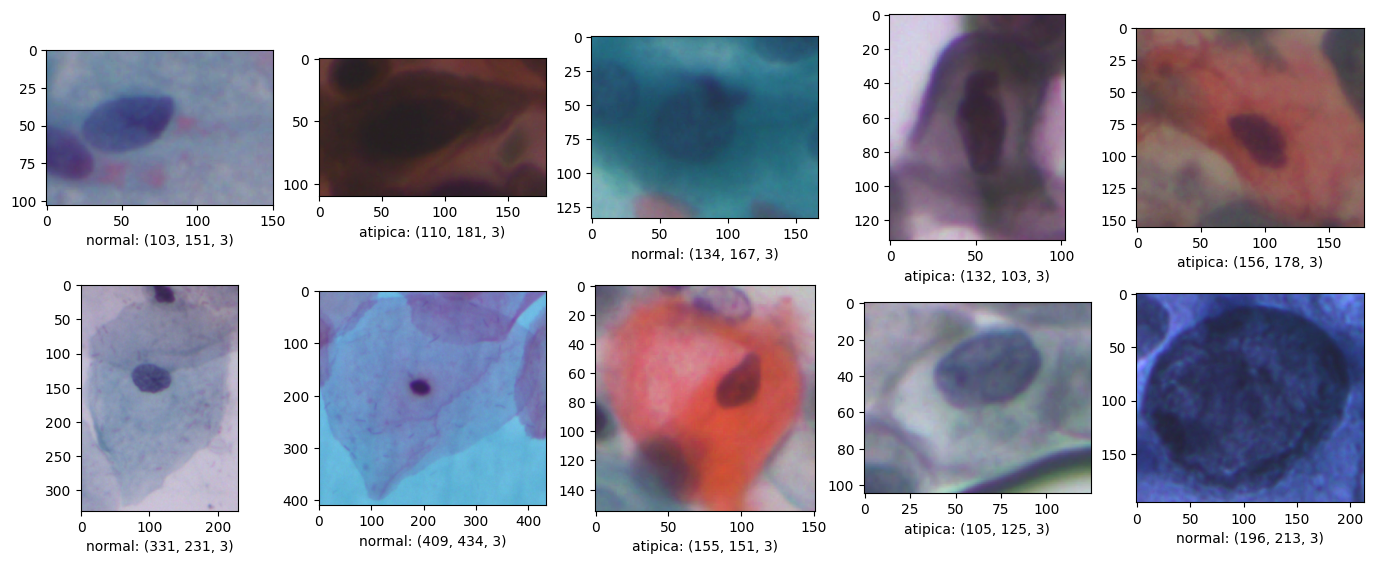

In [25]:
## IMAGENES DEL DATASET 

plt.figure(figsize=(17,17))
for i in range(10):
    image_name = random.choice(files)
    image = imread(DATA_PATH + image_name)
    plt.subplot(5,5, i + 1)
    plt.imshow(image)
    plt.xlabel(f"normal: {image.shape}" if'normal' in image_name else f"atipica: {image.shape}")

Total data: 4049
Category 0: 0.595
Category 1: 0.405
0    2411
1    1638
Name: category (Y), dtype: int64


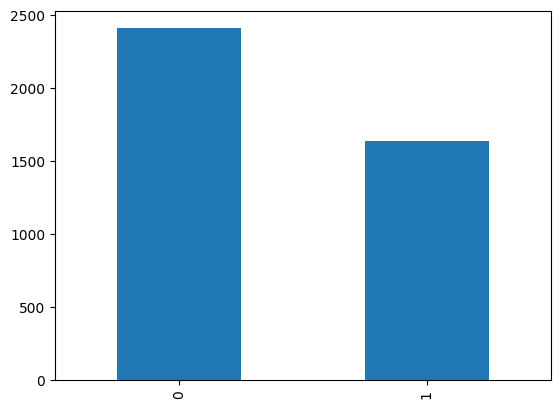

In [26]:
# BALANCE DE DATOS EN LAS CATEGORIAS: celula normal(0) - celula atipica(1)

print('Total data:', len(df_cito))
print('Category 0:',round(len(df_cito[df_cito['category (Y)']==0])/len(df_cito),3))
print('Category 1:',round(len(df_cito[df_cito['category (Y)']==1])/len(df_cito),3))
print(df_cito['category (Y)'].value_counts())
df_cito['category (Y)'].value_counts().plot.bar(); 

Tenemos un dataframe compuesto por:
- 4049 filas, equivalente al numero de imagenes del dataset.
- 2 columnas: *filename* y *category*, con datos tipo object (imágenes) e int64 (enteros) almacenados respectivamente en cada una.
- La columna 'filename' se refiere a los nombres de los archivos de imagen, y 'category' a las etiquetas. Se asigna el valor 0 a las imagenes de células normales y 1 a células atípicas.
- Las categorias de los archivos de imagenes del dataset no están balanceadas.
- No hay ningún valor nulo, ni duplicados. 
- Todos los archivos de imagen se encuentran en formato BMP y no han sido sometidos a ningun tratamiento de imagen previo.

In [27]:
df_cito.info() 
print('\nDuplicated values:', df_cito.duplicated(). sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4049 entries, 0 to 4048
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   filename (X)  4049 non-null   object
 1   category (Y)  4049 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 63.4+ KB

Duplicated values: 0


### **PREPARACION DE DATOS PARA EL TRAINNING**

##### **SPLIT DE SUBGRUPOS: TRAIN, TEST, VALIDATION**

- Train: 63%
- Test: 23%
- Validation: 14%

In [28]:
## SPLIT  CONSERVANDO LA PROPORCION DE CATEGORIAS

X_train, X_test, y_train,y_test = train_test_split(df_cito['filename (X)'], df_cito['category (Y)'], train_size= 0.80, random_state=14, stratify =  df_cito['category (Y)']) 
X_train, X_val,y_train,y_val = train_test_split(X_train, y_train, train_size= 0.85, random_state=14, stratify = y_train)

total_size = len(X_train)+ len(X_test)+len(X_val)
print("Total size:", total_size)
print("Size X_train:", len(X_train))
print("Size X_test:", len(X_test))
print("Size X_val:", len(X_val))

# Porcentajes por subgrupo antes de balancear
print("\nPercentage X_train:", round(len(X_train)/total_size, 2))
print("Percentage X_test:", round(len(X_test)/total_size,2))
print("Percentage X_val:", round(len(X_val)/total_size,2))

Total size: 4049
Size X_train: 2753
Size X_test: 810
Size X_val: 486

Percentage X_train: 0.68
Percentage X_test: 0.2
Percentage X_val: 0.12


In [29]:
# X_train no tiene balanceados los datos, así que hay que equilibrarlos por categorias. Comprobamos también que se conservan proporciones en los tags.
print('Category 0 (X_train):',round(len([0 for i in [0 if 'normal' in file else 1 for file in X_train] if i == 0 ])/len(X_train),3))
print('Category 1 (X_train):',round(len([0 for i in [0 if 'normal' in file else 1 for file in X_train] if i == 1 ])/len(X_train),3))
print('\nCategory 0 (X_test):',round(len([0 for i in [0 if 'normal' in file else 1 for file in X_test] if i == 0 ])/len(X_test),3))
print('Category 1 (X_test):',round(len([0 for i in [0 if 'normal' in file else 1 for file in X_test] if i == 1 ])/len(X_test),3))

Category 0 (X_train): 0.596
Category 1 (X_train): 0.404

Category 0 (X_test): 0.595
Category 1 (X_test): 0.405


Size X_train balanced: 2226
Category 0 X_train balanced: 1113
Category 1 X_train balanced: 1113


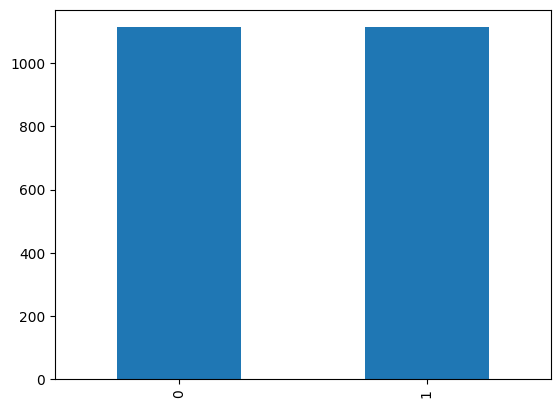

In [30]:
## BALANCEAMOS LAS CATEGORIAS EN TRAIN 

X_train = balanceData(X_train)[0] # nos quedamos con el dataset balanceado -> [0]
print('Size X_train balanced:', len(X_train))
print( 'Category 0 X_train balanced:',len([0 for i in [0 if 'normal' in file else 1 for file in X_train] if i == 0 ]))
print( 'Category 1 X_train balanced:',len([0 for i in [0 if 'normal' in file else 1 for file in X_train] if i == 1 ]))

lista_plot = pd.Series([0 if 'normal' in file else 1 for file in X_train])
df_plot = pd.DataFrame({'category':lista_plot}) 
df_plot['category'].value_counts().plot.bar(); 

In [31]:
# PORCENTAJES DESPUES DE BALANCEAR X_TRAIN
total_size_balanced = len(X_train)+ len(X_test)+len(X_val)
print("Total size balanced:", total_size_balanced)
print("\nPercentage X_train:", round(len(X_train)/total_size_balanced, 2))
print("Percentage X_test:", round(len(X_test)/total_size_balanced,2))
print("Percentage X_val:", round(len(X_val)/total_size_balanced,2))


Total size balanced: 3522

Percentage X_train: 0.63
Percentage X_test: 0.23
Percentage X_val: 0.14


In [32]:
X_train = shuffle(X_train, random_state=14) # Aleatorizamos de nuevo porque al aplicar la función de balanceo se reordenan los datos.

##### **LOAD AND RESIZE DATA**

Usamos la funcion loadImage() para cargar las imágenes y ajustarlas todas a la misma resolución, es decir hacerles un resize (dimensiones).  

Decidimos cargarlas en color porque el scoring del modelo mejoraba considerablemente si no reducimos los features con escala de grises (probamos previamente ambas opciones). En caso de querer cargarlas en escala de grises especifica el parametro '*grey_scale* = True' en la funcion.

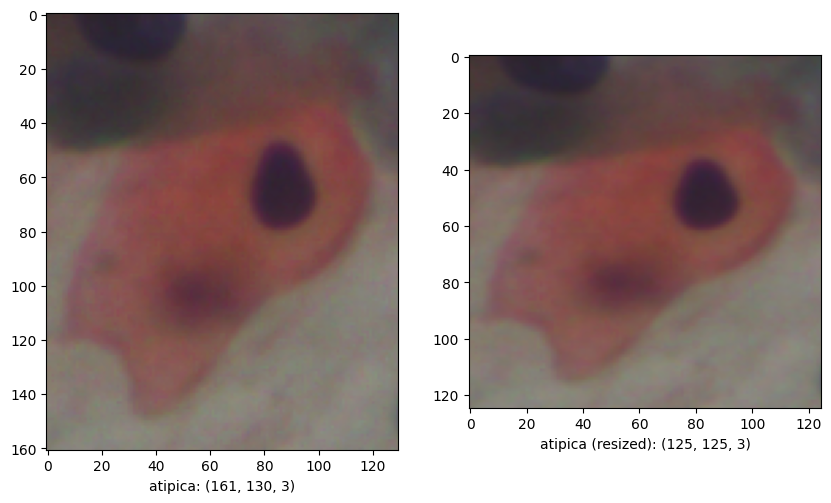

In [33]:
## EJEMPLO DE IMAGEN ANTES Y DESPUES DE APLICARLE RESIZE

plt.figure(figsize=(10, 10))

imgname = random.choice(files)
image = imread(DATA_PATH + imgname)
image_reshaped = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel(f"normal: {image.shape}" if'normal' in imgname else f"atipica: {image.shape}")

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(image_reshaped)
plt.xlabel(f"normal (resized): {image_reshaped.shape}" if'normal' in imgname else f"atipica (resized): {image_reshaped.shape}");

In [34]:
# Almacenamos las imagenes procesadas, con el resize aplicado en las variables (reasignamos y).
X_train,y_train = loadImage(X_train, DATA_PATH, IMAGE_HEIGHT, IMAGE_WIDTH)
X_test,y_test = loadImage(X_test, DATA_PATH, IMAGE_HEIGHT, IMAGE_WIDTH)
X_val,y_val = loadImage(X_val, DATA_PATH, IMAGE_HEIGHT, IMAGE_WIDTH)

In [35]:
print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)
print("\nShape X_test:", X_test.shape)
print("Shape y_test:", y_test.shape)
print("\nShape X_val:", X_val.shape)
print("Shape y_val:", y_val.shape)

Shape X_train: (2226, 125, 125, 3)
Shape y_train: (2226,)

Shape X_test: (810, 125, 125, 3)
Shape y_test: (810,)

Shape X_val: (486, 125, 125, 3)
Shape y_val: (486,)


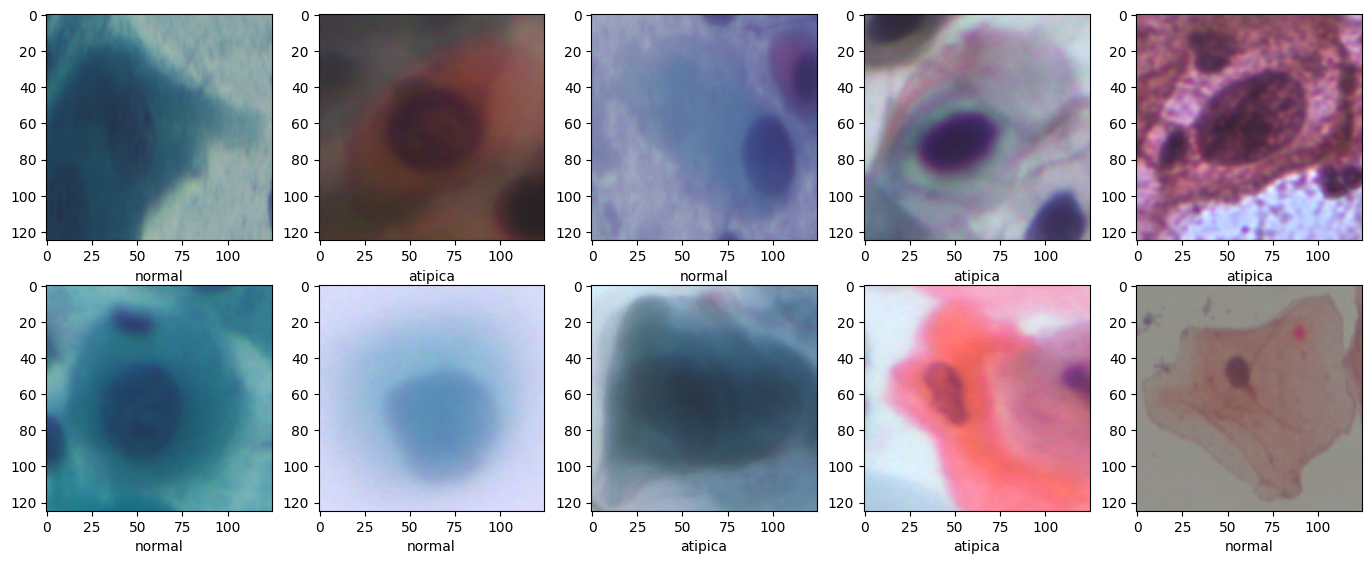

In [36]:
## IMAGENES DE PRUEBA

tags = ['normal','atipica']
plt.figure(figsize=(17,17))
for i in range(10):
    plt.subplot(5,5, i + 1)
    plt.imshow(X_train[i])
    plt.xlabel(tags[y_train[i]])

##### **ESCALADO DE DATOS**

Ajustamos todos los valores de los pixeles entre 0 y 1.

In [37]:
## ESCALADO MANUAL CON LA FORMULA (X-Xmin/Xmax-Xmin)

X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))
X_val = (X_val - np.min(X_val)) / (np.max(X_val) - np.min(X_val))

print('Min value pixel (train escalated):', np.min(X_train))
print('Max value pixel (train escalated):', np.max(X_train))
print('Min value pixel (test escalated):', np.min(X_test))
print('Max value pixel (test escalated):', np.max(X_test))
print('Min value pixel (val escalated):', np.min(X_val))
print('Max value pixel (val escalated):', np.max(X_val))

Min value pixel (train escalated): 0.0
Max value pixel (train escalated): 1.0
Min value pixel (test escalated): 0.0
Max value pixel (test escalated): 1.0
Min value pixel (val escalated): 0.0
Max value pixel (val escalated): 1.0


In [38]:
# ESCALAR CON PREPROCESSING DA ERROR PORQUE LOS DATOS SON MATRICES 3D Y EL MÉTODO ESCALA SOLO CON 2D
'''
X_train = preprocessing.StandardScaler().fit_transform(X_train)
X_test = preprocessing.StandardScaler().transform(X_test)
X_val = X_train = preprocessing.StandardScaler().transform(X_val)

'''

##### **GUARDAR/CARGAR DATOS**

In [39]:
np.savez('../data/data.npz', X_train= X_train, y_train= y_train, X_test = X_test, y_test = y_test, X_val = X_val, y_val= y_val)

In [40]:
data = np.load('../data/data.npz')

X_train = data['X_train']
X_test = data['X_test']
X_val = data['X_val']
y_train = data['y_train']
y_test = data['y_test']
y_val = data['y_val']

### **ARQUITECTURA DEL MODELO**


1. **Tres capas convolucionales** con 32, 64 y 128 kernels respectivamente que extraerá los features de las imágenes, con dimensión 3x3 y función de activación relu.  
Tras cada capa convolucional se aplica una capa de reducción 2x2 (max pooling) que reducirá las dimensiones de las imágenes, y una capa de dropout 0.25 para apagar neuronas y evitar overfitting.

2. **Tres capas de clasificación**:
   - Input layer. Aplanamiento de los datos en la red (flatten)
   - Hiden layer. Compuesta por una capa de 512 neuronas con función de activación relu y una capa de dropout 0.5.
   - Output layer (predicción). Compuesta por una única neurona con función de activación sigmoide, ideal al ser un clasificador binario. Otra opción sería 2 neuronas de salida con función de activación softmax: ```model.add(Dense(2, activation='softmax'))```

- **Opmizador**: adam.  

- **Función de error o pérdida**: binary crossentropy.

In [41]:
model = Sequential()

## CAPAS DE CONVOLUCION-POOLING

# PRIMERA CAPA 
model.add(Conv2D(filters = 32, kernel_size= (3,3), activation='relu',
                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# SEGUNDA CAPA
model.add(Conv2D(filters = 64, kernel_size= (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# TERCERA CAPA
model.add(Conv2D(filters = 128, kernel_size= (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


## CAPAS DE CLASIFICACION

# INPUT LAYER (ENTRADA.Aplana las images 3D a 1D)
model.add(Flatten())

# HIDEN LAYER
model.add(Dense(units = 512, activation= 'relu'))
model.add(Dropout(0.5))

# OUTPUT LAYER 
model.add(Dense(units= 1, activation= 'sigmoid'))

# CONFIGURACION DE EJECUCION (COMPILE)
model.compile(optimizer='adam', loss='binary_crossentropy',
             metrics=['accuracy']) 

In [42]:
model.summary() # EJ: sumatorio de pesos de la primera capa 896 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 123, 123, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 61, 61, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 29, 29, 64)       

### **ENTRENAMIENTO Y METRICAS DEL MODELO** 

In [43]:
earlystop =EarlyStopping(patience= PATIENCE, restore_best_weights= True) # Interrumpe el entrenamiento cuando no hay progreso en el set de validación.

# checkpoint = ModelCheckpoint('../models/checkpoint_model.h5')

In [44]:
history = model.fit(X_train, y_train,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [earlystop],
                    validation_data= (X_val, y_val),
                    verbose= 2)

Epoch 1/50


KeyboardInterrupt: 

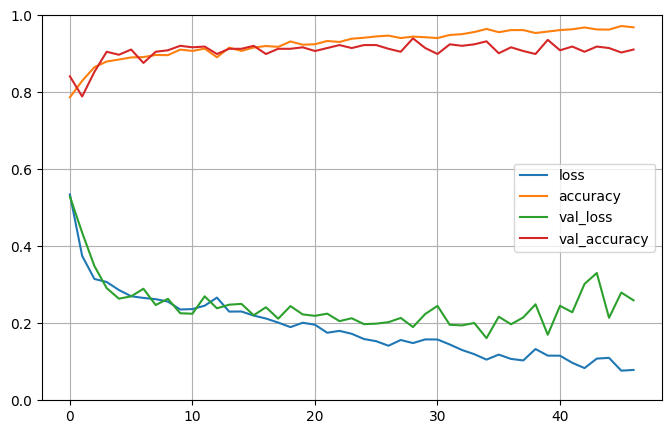

In [ ]:
## GRAFICA DE LAS METRICAS JUNTO A LA FUNCION DE PERDIDA DE VALIDACION Y TRAIN

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
# pd.DataFrame(history.history)

In [ ]:
## BEST SCORING
best_score = model.evaluate(X_train,y_train)
print("Mejor métrica de train: loss y accuracy", best_score)

74/74 [==============================] - 8s 101ms/step - loss: 0.0701 - accuracy: 0.9751
Mejor métrica de train: loss y accuracy [0.07007362693548203, 0.9750633835792542]


In [ ]:
# MATRIZ DE CONFUSIÓN 

confusion_matrix(y_train, model.predict(X_train).round(0))

74/74 [==============================] - 8s 106ms/step


array([[1172,   11],
       [  48, 1135]], dtype=int64)

In [ ]:
# MATRIZ DE CONFUSIÓN (NORMALIZED)

confu_mat = confusion_matrix(y_train, model.predict(X_train).round(0), normalize = 'pred')
confu_mat

74/74 [==============================] - 8s 106ms/step


array([[0.96065574, 0.0095986 ],
       [0.03934426, 0.9904014 ]])

<AxesSubplot:>

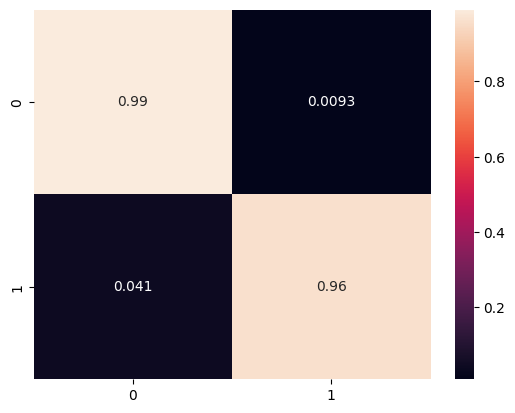

In [ ]:
sns.heatmap(confu_mat/np.sum(confu_mat,axis=1), annot=True)

### **EVALUACION EN X_TEST**

In [ ]:
## METRICA DE PREDICCIONES EN EL CONJUNTO DE TEST

results = model.evaluate(X_test, y_test) 
print("Métrica de test: loss y accuracy", results)

19/19 [==============================] - 2s 92ms/step - loss: 0.2592 - accuracy: 0.9293
Métrica de test: loss y accuracy [0.2592456638813019, 0.9292762875556946]


In [ ]:
predictions = model.predict(X_test[-1:]).round(0) # Hay que respetar el tamaño del tensor a la entrada en la red.

1/1 [==============================] - 0s 32ms/step


##### **PREDICCIONES CON OTROS DATOS** 

In [ ]:
'''
image = imread('./cito_test.png')
plt.imshow(image);

testing_image = np.array([cv2.resize(imread('./cito_test.png'),(IMAGE_WIDTH,IMAGE_HEIGHT))/255.0])
model.predict(testing_image)

'''

### **SAVE/LOAD MODEL** 

In [ ]:
model.save("../models/model_125.h5")
#model = keras.models.load_model("../models/model_125.h5")